In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

from raptcr.constants.parsing import parse_yfv_repertoires, parse_britanova_repertoires
from raptcr.indexing import FlatIndex
from raptcr.hashing import TCRDistEncoder
from raptcr.background import SyntheticBackground
from raptcr.neighbors import NeighborEnrichment
from raptcr.background import generate_olga_sequences_multi
from raptcr.neighbors import tcr_dict_to_df, index_neighbors

## Britanova data set
### Cord blood
Read in the data and compute the neighbors within a 12.5 TCRDist for every unique V-CDR3 combination in the repertoire.

In [194]:
# Parse input data
cordblood = parse_britanova_repertoires("./data/britanova/A5-S14.txt.gz")
cordblood["junction"] = cordblood["junction"].str.lower()

encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit() # Embedding function
neighbor_counter = NeighborEnrichment(repertoire=cordblood, hasher=encoder, radius=12.5)
neighbor_counter.compute_neighbors() # Calculate the neighbors distribution in the foreground

,junction,junction_aa,v_call,j_call,clone_count,clone_fraction
0,tgtgccagcagtttacccttactacacaatgagcagttcttc,CASSLPLLHNEQFF,TRBV12-4*01,TRBJ2-1*01,126,0.000322
1,tgtgccagcagtcccggcacagatacgcagtatttt,CASSPGTDTQYF,TRBV27*01,TRBJ2-3*01,101,0.000258
2,tgtgccagcagcttagggacagggggctacgagcagtacttc,CASSLGTGGYEQYF,TRBV11-2*01,TRBJ2-7*01,97,0.000248
3,tgtgccagcagccttacagggaactggtggtcctacgagcagtacttc,CASSLTGNWWSYEQYF,TRBV11-1*01,TRBJ2-7*01,87,0.000222
4,tgcgccagcagccaagatcggcagggcacagatacgcagtatttt,CASSQDRQGTDTQYF,TRBV4-1*01,TRBJ2-3*01,87,0.000222


### Adult

In [12]:
adult = parse_britanova_repertoires("./data/britanova/A3-i101.txt.gz")
adult["junction"] = adult["junction"].str.lower()

seq_gen = SyntheticBackground(repertoire=adult, n=1)
adult_shuff = seq_gen.shuffled_repertoire(factor=1)

parse_tcr_junctions: 0 264754
parse_tcr_junctions: 50000 264754
parse_tcr_junctions: 100000 264754
parse_tcr_junctions: 150000 264754
parse_tcr_junctions: 200000 264754
parse_tcr_junctions: 250000 264754
success_rate: 92.79


In [16]:
print("Building index")
encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()
index = FlatIndex(hasher=encoder)
index.add(adult_shuff)
print("Computing neighbors")
nbrs = index_neighbors(query=adult, index=index, r=12.5)

Building index
Computing neighbors


In [28]:
shuff_counts = tcr_dict_to_df(nbrs,cutoff=-1,add_counts=True)
shuff_counts["neighbors"] += 1
shuff_counts = shuff_counts.rename(columns={"neighbors":"expected_shuffled_single"})

a3101 = pd.read_csv("./analysis/qfactor/A3-101_neighbors.txt", sep="\t")
a3101 = a3101.merge(shuff_counts, on=["v_call","junction_aa"])
a3101.head()

,v_call,junction_aa,bg_vmatch,fg,expected_vmatch,bg_shuffled,expected_shuffled,bg_olga,expected_olga,expected_shuffled_single
0,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0,1
1,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0,1
2,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0,1
3,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0,1
4,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0,1


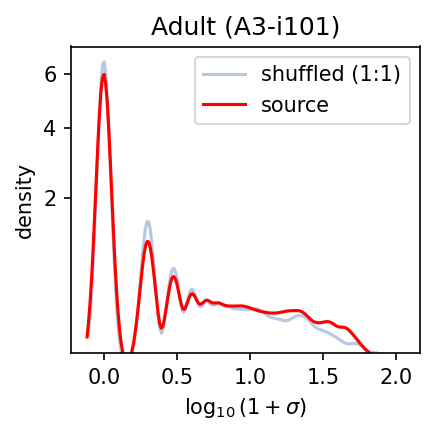

In [42]:
def plot_neighbor_kde_2(sample, q=1, ax=None, sqrt=True, title="", ylab=""):

    if ax is None:
        fig, ax = plt.subplots(dpi=150, figsize=(3,3))

    # x1 = (sample.expected_olga*q+1).apply(lambda x: np.log10(x))
    # x2 = (sample.expected_vmatch*q+1).apply(lambda x: np.log10(x))
    x = (sample.expected_shuffled_single*q+1).apply(lambda x: np.log10(x))
    source = (sample.fg+1).apply(lambda x: np.log10(x))

    sns.kdeplot(x=x, alpha=.9, c="lightsteelblue", label="shuffled (1:1)", ax=ax)
    # sns.kdeplot(x=x2, alpha=.9, c="royalblue", label=r"$\mathregular{OLGA_{V-CDR3}}$", ax=ax)
    # sns.kdeplot(x=x3, alpha=.9, c="darkblue", label="shuffled", ax=ax)
    sns.kdeplot(x=source, c="red", label="source", ax=ax)
    ax.set_xlabel(r"$\log_{10}(1+\sigma)$")
    ax.set_ylabel(ylab)
    ax.set_title(title)
    if sqrt:
        ax.set_yscale("squareroot")

mscale.register_scale(SquareRootScale)

fig, ax = plt.subplots(dpi=150, figsize=(3,3))
plot_neighbor_kde_2(a3101, ylab="density", title="Adult (A3-i101)", ax=ax)
ax.legend()
fig.tight_layout()

Some functions for configuring plots

In [31]:
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**0.5
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)**2
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()

def plot_neighbor_kde(sample, q=1, ax=None, sqrt=True, title="", ylab=""):

    if ax is None:
        fig, ax = plt.subplots(dpi=150, figsize=(3,3))

    x1 = (sample.expected_olga*q+1).apply(lambda x: np.log10(x))
    x2 = (sample.expected_vmatch*q+1).apply(lambda x: np.log10(x))
    x3 = (sample.expected_shuffled*q+1).apply(lambda x: np.log10(x))
    source = (sample.fg+1).apply(lambda x: np.log10(x))

    sns.kdeplot(x=x1, alpha=.9, c="lightsteelblue", label=r"$\mathregular{OLGA_{random}}$", ax=ax)
    sns.kdeplot(x=x2, alpha=.9, c="royalblue", label=r"$\mathregular{OLGA_{V-CDR3}}$", ax=ax)
    sns.kdeplot(x=x3, alpha=.9, c="darkblue", label="shuffled", ax=ax)
    sns.kdeplot(x=source, c="red", label="source", ax=ax)
    ax.set_xlabel(r"$\log_{10}(1+\sigma)$")
    ax.set_ylabel(ylab)
    ax.set_title(title)
    if sqrt:
        ax.set_yscale("squareroot")

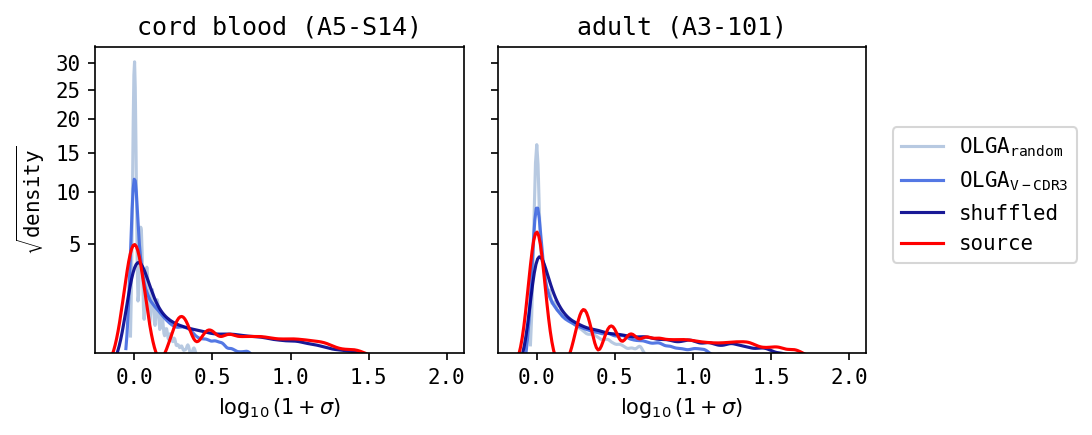

In [294]:
fig, ax = plt.subplots(ncols=2, dpi=150, figsize=(6,3), sharex=True, sharey=True)
plot_neighbor_kde(sample=a5s14, ax=ax[0], title="cord blood (A5-S14)", ylab=(r"$\mathregular{\sqrt{density}}$"))
plot_neighbor_kde(sample=a3101, ax=ax[1], title="adult (A3-101)")

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(.9,.4), bbox_to_anchor=[1,.4])
fig.tight_layout()
fig.savefig("./fig/neighbor_density_britanova.png", format="png", dpi=500, bbox_inches="tight")

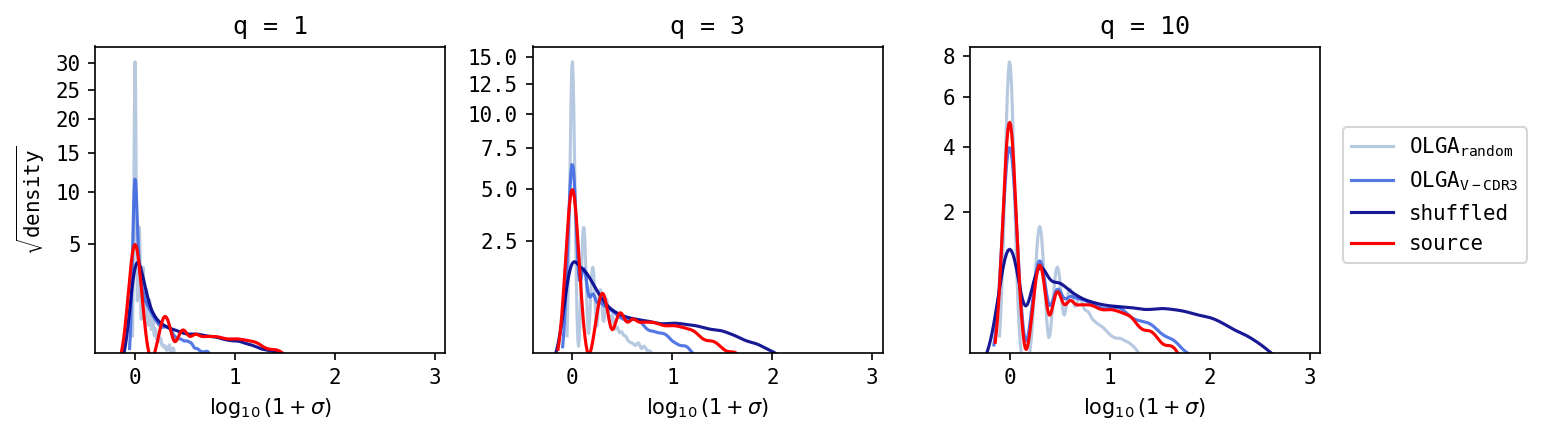

In [305]:
fig, ax = plt.subplots(ncols=3, dpi=150, figsize=(9,3), sharex=True, sharey=False)
plot_neighbor_kde(sample=a5s14, q=1, ax=ax[0], title="q = 1", ylab=(r"$\mathregular{\sqrt{density}}$"))
plot_neighbor_kde(sample=a5s14, q=3, ax=ax[1], title="q = 3")
plot_neighbor_kde(sample=a5s14, q=10, ax=ax[2], title="q = 10")
handles, labels = ax[2].get_legend_handles_labels()
fig.legend(handles, labels, loc=(.9,.4), bbox_to_anchor=[1,.4])
fig.tight_layout()
fig.savefig("./fig/neighbor_density_q_A5-S14.png", format="png", dpi=500, bbox_inches="tight")

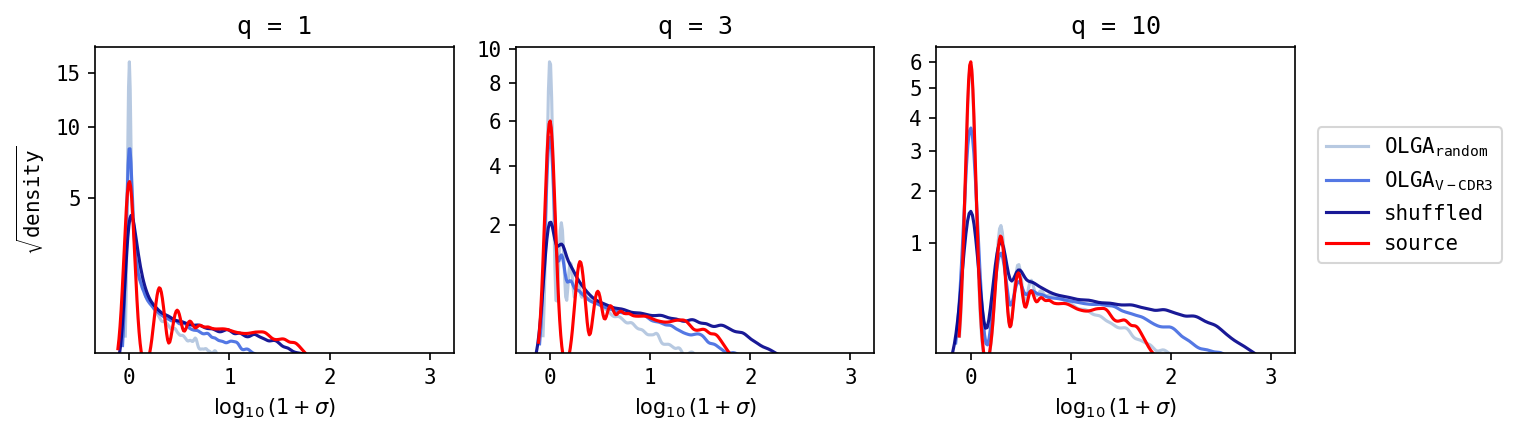

In [307]:
fig, ax = plt.subplots(ncols=3, dpi=150, figsize=(9,3), sharex=True, sharey=False)
plot_neighbor_kde(sample=a3101, q=1, ax=ax[0], title="q = 1", ylab=(r"$\mathregular{\sqrt{density}}$"))
plot_neighbor_kde(sample=a3101, q=3, ax=ax[1], title="q = 3")
plot_neighbor_kde(sample=a3101, q=10, ax=ax[2], title="q = 10")
handles, labels = ax[2].get_legend_handles_labels()
fig.legend(handles, labels, loc=(.9,.4), bbox_to_anchor=[1,.4])
fig.tight_layout()
fig.savefig("./fig/neighbor_density_q_A3-101.png", format="png", dpi=500, bbox_inches="tight")

NameError: name 'adult' is not defined

In [52]:
# cordblood = parse_britanova_repertoires("./data/britanova/A5-S14.txt.gz")
# shuffled = pd.read_csv("./analysis/background_testing/shuffled/A5-S14_background_shuffled.txt", sep="\t")

encoder = TCRDistEncoder(aa_dim=8,full_tcr=True).fit()
index = FlatIndex(hasher=encoder)
index.add(sequences)

# enricher = NeighborEnrichment(repertoire=cordblood, hasher=encoder)
# enricher.compute_neighbors()

res = index_in_chunks(query=cordblood, index=index)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000


In [45]:
a5s14 = res.merge(tcr_dict_to_df(enricher.nbr_counts, cutoff=-1, add_counts=True), on=["v_call","junction_aa"])
a5s14 = a5s14.rename(columns={"neighbors_x":"bg_vmatched","neighbors_y":"fg"})
a5s14.head()

,v_call,junction_aa,bg_vmatched,fg
0,TRBV12-4*01,CASSLPLLHNEQFF,0,0
1,TRBV27*01,CASSPGTDTQYF,5,1
2,TRBV27*01,CASSPGTDTQYF,5,1
3,TRBV11-2*01,CASSLGTGGYEQYF,1,4
4,TRBV11-2*01,CASSLGTGGYEQYF,1,4


In [53]:
res = res.rename(columns={"neighbors":"bg_olga"})
a5s14 = a5s14.merge(res, on=["v_call","junction_aa"])
a5s14.head()

,v_call,junction_aa,bg_vmatched,fg,bg_shuffled,bg_olga
0,TRBV12-4*01,CASSLPLLHNEQFF,0,0,0,0
1,TRBV27*01,CASSPGTDTQYF,5,1,14,3
2,TRBV27*01,CASSPGTDTQYF,5,1,14,3
3,TRBV27*01,CASSPGTDTQYF,5,1,14,3
4,TRBV27*01,CASSPGTDTQYF,5,1,14,3


In [54]:
a5s14["expected_shuffled"] = a5s14["bg_shuffled"]/10
a5s14["expected_vmatched"] = a5s14["bg_vmatched"]/10
a5s14["expected_olga"] = a5s14["bg_olga"]/10
a5s14

,v_call,junction_aa,bg_vmatched,fg,bg_shuffled,bg_olga,expected_shuffled,expected_vmatched,expected_olga
0,TRBV12-4*01,CASSLPLLHNEQFF,0,0,0,0,0.0,0.0,0.0
1,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
2,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
3,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
4,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
...,...,...,...,...,...,...,...,...,...
51495,TRBV29-1*01,CSVGYTF,11,3,12,3,1.2,1.1,0.3
51496,TRBV29-1*01,CSVGGYF,16,2,9,3,0.9,1.6,0.3
51497,TRBV29-1*01,CSVEAFF,19,2,13,3,1.3,1.9,0.3
51498,TRBV29-1*01,CSDEKYF,18,3,10,1,1.0,1.8,0.1


In [7]:
sequences["v_call"] = sequences["v_gene"] + "*01"
sequences = sequences[["v_call","junction_aa"]]
sequences

,v_call,junction_aa
0,TRBV27*01,CASSLMGGTSEKLFF
1,TRBV7-3*01,CASRGSNTEAFF
2,TRBV6-5*01,CASSYVRRNEQYF
3,TRBV6-5*01,CATLQGGKKLFF
4,TRBV3-1*01,CASSCSGTQYEQYF
...,...,...
2639995,TRBV6-3*01,CASSYLESSSGVSYNEQFF
2639996,TRBV25-1*01,CASSGVRDRGVRAFYSNQPQHF
2639997,TRBV7-9*01,CASSGRDRDDSGNTIYF
2639998,TRBV24-1*01,CATSDGPSTNQPQHF


In [6]:
df = parse_yfv_repertoires("./analysis/background_testing/yfv/repertoires/P1_pre0_F1_.txt.gz")
# df = df[df.clone_count>2]
df['junction'] = df.junction.str.lower()
seqgen = SyntheticBackground(repertoire=df, n=1e6)

encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()

enricher = NeighborEnrichment(repertoire=df, hasher=encoder)
enricher.compute_neighbors()
res_df = tcr_dict_to_df(enricher.nbr_counts, cutoff=0, add_counts=True)

In [16]:
intervals = [i for i in range(0,len(res_df),500)]

# shuffled_backgound = seqgen.shuffled_repertoire(factor=5)
index = FlatIndex(hasher=encoder)
index.add(sequences)

res = pd.DataFrame(columns=['v_call','junction_aa','neighbors'])
n = 1000
while n < len(res_df):
    # if n % 50000 == 0:
    print(n)
    bgn = index_neighbors(query=res_df[n-1000:n], r=12.5, index=index)
    n += 1000
    res = pd.concat([res,tcr_dict_to_df(bgn, cutoff=-1, add_counts=True)])
n -= 1000
bgn = index_neighbors(query=res_df[n:-1], r=12.5, index=index)
res = pd.concat([res,tcr_dict_to_df(bgn, cutoff=-1, add_counts=True)])
res["neighbors"] += 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [23]:
final = res_df.merge(res.reset_index(drop=True),on=["v_call","junction_aa"])
final = final.rename(columns={"neighbors_x":"fg","neighbors_y":"bg"})
final

,v_call,junction_aa,fg,bg
0,TRBV6-2*01,CASSNSDRTYGDNEQFF,0,0
1,TRBV2*01,CASSVLREEQYF,0,0
2,TRBV7-2*01,CASSRRHLGNTGELFF,0,0
3,TRBV24-1*01,CATSSVLTQQETQYF,0,0
4,TRBV5-1*01,CASSPATTSGQETQYF,0,0
...,...,...,...,...
183382,TRBV29-1*01,CSGGGVF,4,12
183383,TRBV7-9*01,CAAPDF,0,6
183384,TRBV27*01,CASAPF,0,5
183385,TRBV19*01,CAKRIF,0,6


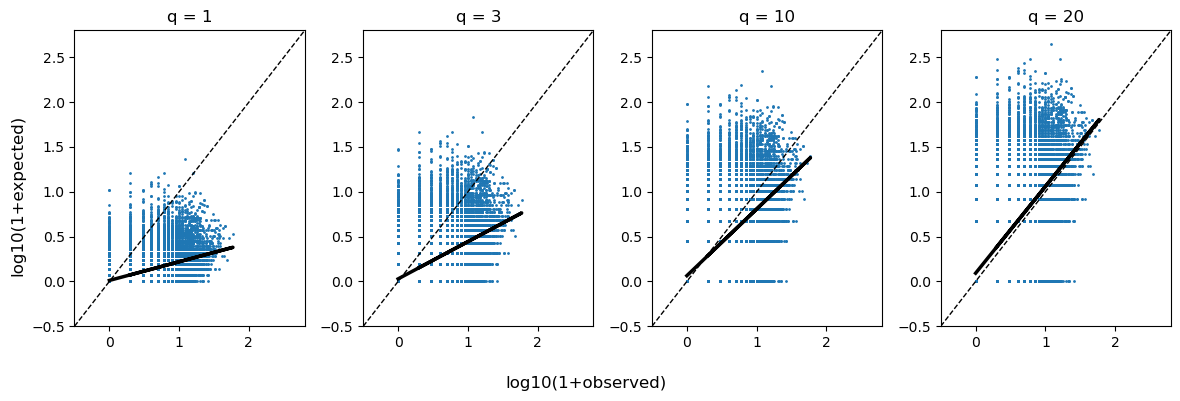

In [29]:
final["expected"] = (final.bg / 1e6) * 183387

qs = [1,3,10,20]
fig, ax = plt.subplots(ncols=len(qs), figsize=(12,4))
for col,q in enumerate(qs):
    x = (final.fg+1).apply(lambda x: np.log10(x))
    y = (final.expected*q+1).apply(lambda x: np.log10(x)) 
    ax[col].scatter(x=x, y=y, s=1)
    ax[col].set_xlim(-.5,2.8)
    ax[col].set_ylim(-.5,2.8)
    ax[col].plot([-.5,2.8],[-.5,2.8], c="black", lw=1, ls="--")
    ax[col].set_title(f"q = {q}")
    slope, intercept = np.polyfit(x, y, deg=1)
    ax[col].plot(x, slope * x + intercept, color="k", lw=2.5)
fig.supxlabel("log10(1+observed)")
fig.supylabel("log10(1+expected)")
fig.tight_layout()


In [10]:
# # vmatched = pd.read_csv("./analysis/background_testing/v_matched/A3-i101_background_vmatch.txt", sep="\t")
# brit = parse_britanova_repertoires("./data/britanova/A3-i101.txt.gz")
# brit = brit.drop(columns=["junction","clone_count","clone_fraction"])

# # sequences["v_call"]

# encoder = TCRDistEncoder(aa_dim=8,full_tcr=True).fit()
# index = FlatIndex(hasher=encoder)
# index.add(sequences)

res = index_in_chunks(query=brit,index=index)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [7]:
brit = parse_britanova_repertoires("./data/britanova/A3-i101.txt.gz")
brit = brit.drop(columns=["junction","clone_count","clone_fraction"])

,junction_aa,v_call,j_call
0,CATATSGEHTDTQYF,TRBV27*01,TRBJ2-3*01
1,CASSLAGLPSGRTEAFF,TRBV13*01,TRBJ1-1*01
2,CASSFWTSGQETQYF,TRBV3-1*01,TRBJ2-5*01
3,CSARGGSGIYNEQFF,TRBV20-1*01,TRBJ2-1*01
4,CASSPSNYGYTF,TRBV5-6*01,TRBJ1-2*01
...,...,...,...
264749,CSATQHF,TRBV29-1*01,TRBJ1-5*01
264750,CSEAQYF,TRBV20-1*01,TRBJ2-7*01
264751,CRSGEYF,TRBV20-1*01,TRBJ2-7*01
264752,CRNEQFF,TRBV20-1*01,TRBJ2-1*01


In [9]:
def index_in_chunks(query,index,chnksz=1000):
    n = chnksz
    res = pd.DataFrame(columns=['v_call','junction_aa','neighbors'])
    while n < len(query):
        print(n)
        bgn = index_neighbors(query=query[n-1000:n], r=12.5, index=index)
        n += 1000
        res = pd.concat([res,tcr_dict_to_df(bgn, cutoff=-1, add_counts=True)])
    n -= 1000
    bgn = index_neighbors(query=query[n:-1], r=12.5, index=index)
    res = pd.concat([res,tcr_dict_to_df(bgn, cutoff=-1, add_counts=True)])
    res["neighbors"] += 1
    return res

# res = index_in_chunks(query=brit,index=index)

In [19]:
ne = NeighborEnrichment(repertoire=res,hasher=encoder)
ne.compute_neighbors()

In [36]:
final.to_csv("./analysis/qfactor/A3-101_neighbors.txt", sep="\t", index=False)

In [14]:
final = pd.read_csv("./analysis/qfactor/A3-101_neighbors.txt", sep="\t")
final = final.merge(res, on=["v_call","junction_aa"])
final["expected_olga"] = final.bg_olga / 10
final

,v_call,junction_aa,bg_vmatch,fg,expected_vmatch,bg_shuffled,expected_shuffled,bg_olga,expected_olga
0,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0
1,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0
2,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0
3,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0
4,TRBV27*01,CATATSGEHTDTQYF,0,7,0.0,2,0.2,0,0.0
...,...,...,...,...,...,...,...,...,...
311786,TRBV29-1*01,CSAQKYF,21,2,2.1,17,1.7,11,1.1
311787,TRBV29-1*01,CSATQHF,36,1,3.6,39,3.9,23,2.3
311788,TRBV20-1*01,CSEAQYF,42,5,4.2,42,4.2,65,6.5
311789,TRBV20-1*01,CRSGEYF,18,1,1.8,13,1.3,37,3.7


In [12]:
# shuffled = pd.read_csv("./analysis/qfactor/A3-101_shuffled_background.txt", sep="\t")
# shuffled = shuffled.drop(columns=["j_call","junction"])
# encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()
# index = Flabrit = parse_britanova_repertoires("./data/britanova/A3-i101.txt.gz")
brit = brit.drop(columns=["junction","clone_count","clone_fraction"])tIndex(hasher=encoder)
# index.add(shuffled)
# del shuffled
res = index_in_chunks(query=brit, index=index)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [66]:
a5s14.to_csv("./analysis/qfactor/A5-S14_neighbors.txt", sep="\t", index=False)

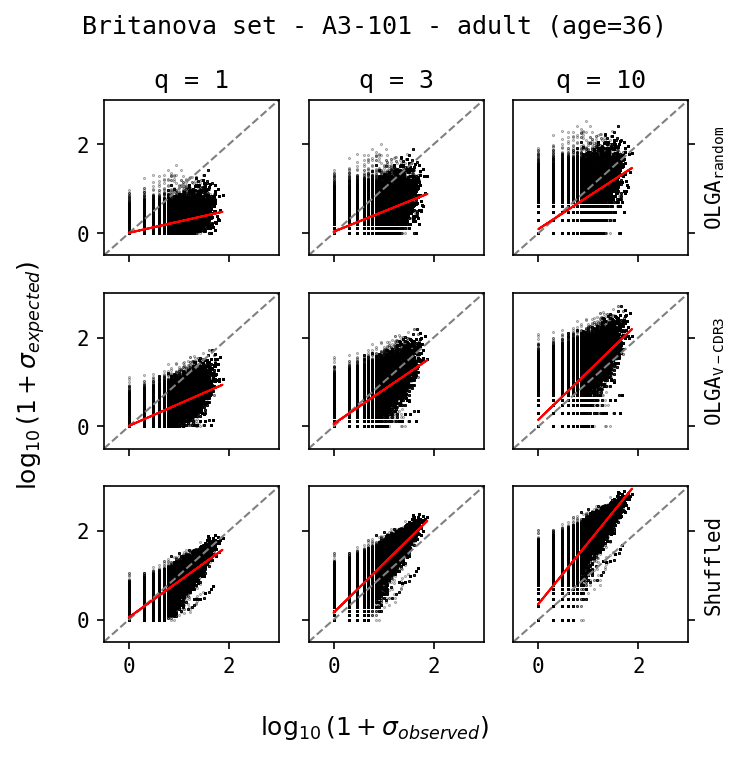

In [154]:
plt.rcParams["font.family"] = "monospace"

qvals = [1,3,10]
backgrounds = ["expected_olga","expected_vmatch","expected_shuffled"]
fig, ax = plt.subplots(
    ncols=len(qvals), nrows=len(backgrounds),
    dpi=150, figsize=(5,5),
    sharex=True, sharey=True
    )

for row,model in enumerate(backgrounds): 
    for col,q in enumerate(qvals):
        x = (a3101.fg+1).apply(lambda x: np.log10(x))
        y = (a3101[model]*q+1).apply(lambda x: np.log10(x))
        ax[row,col].scatter(x=x, y=y, s=.1, c="black", alpha=.5)
        ax[row,col].set_xlim(-.5,3)
        ax[row,col].set_ylim(-.5,3)
        ax[row,col].plot([-.5,3],[-.5,3], c="grey", lw=1, ls="--")
        slope, intercept = np.polyfit(x, y, deg=1)
        ax[row,col].plot(x, slope*x+intercept, color="r", lw=1)
        ax[0,col].set_title(f"q = {q}")
        ax[row,2].yaxis.set_label_position("right")
        ax[row,2].yaxis.tick_right()
ax[0,2].set_ylabel(r"$\mathregular{OLGA_{random}}$")
ax[1,2].set_ylabel(r"$\mathregular{OLGA_{V-CDR3}}$")
ax[2,2].set_ylabel("Shuffled")

fig.supxlabel(r"$\log_{10}(1+\sigma_{observed})$")
fig.supylabel(r"$\log_{10}(1+\sigma_{expected})$")
fig.suptitle("Britanova set - A3-101 - adult (age=36)")

# fig.subplots_adjust(left=1.5, bottom=0.15, right=2, top=0.85, wspace=2, hspace=None)
# fig.subplots_adjust(left=0.2, bottom=0.15, right=0.85, top=0.85, wspace=None, hspace=None)

fig.tight_layout()
fig.savefig("./fig/qvalues_A3-101.png", format="png", dpi=500)

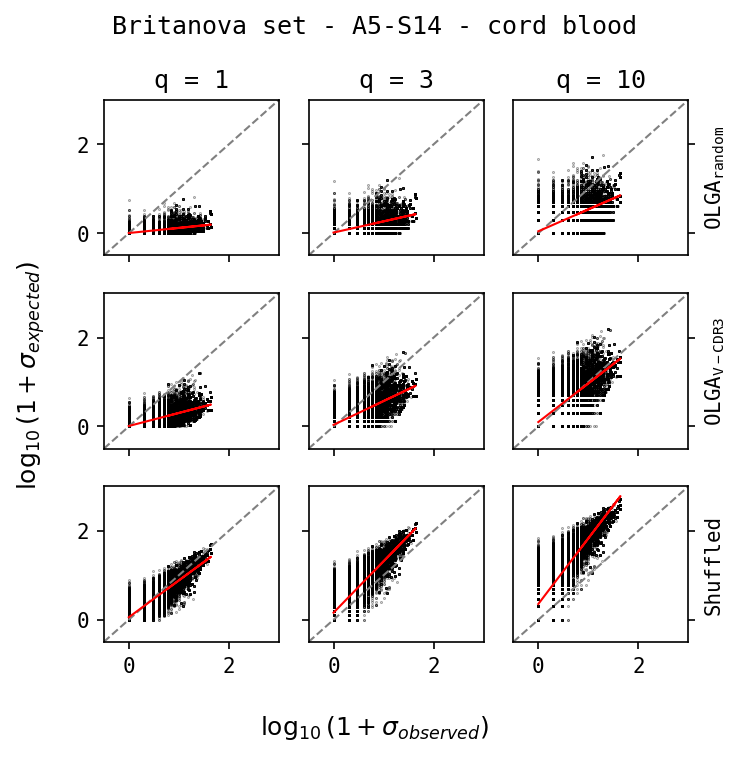

In [152]:
from scipy.stats import gaussian_kde

qvals = [1,3,10]
backgrounds = ["expected_olga","expected_vmatched","expected_shuffled"]
fig, ax = plt.subplots(
    ncols=len(qvals), nrows=len(backgrounds),
    dpi=150, figsize=(5,5),
    sharex=True, sharey=True
    )

for row,model in enumerate(backgrounds): 
    for col,q in enumerate(qvals):
        x = (a5s14.fg+1).apply(lambda x: np.log10(x))
        y = (a5s14[model]*q+1).apply(lambda x: np.log10(x))
        # xy = np.vstack([x,y])
        # z = gaussian_kde(xy)(xy)
        # idx = z.argsort()
        # x, y, z = x[idx], y[idx], z[idx]
        ax[row,col].scatter(x=x, y=y, s=.1, c="black", alpha=.5)
        ax[row,col].set_xlim(-.5,3)
        ax[row,col].set_ylim(-.5,3)
        ax[row,col].plot([-.5,3],[-.5,3], c="grey", lw=1, ls="--")
        slope, intercept = np.polyfit(x, y, deg=1)
        ax[row,col].plot(x, slope*x+intercept, color="r", lw=1)
        ax[0,col].set_title(f"q = {q}")
        ax[row,2].yaxis.set_label_position("right")
        ax[row,2].yaxis.tick_right()
ax[0,2].set_ylabel(r"$\mathregular{OLGA_{random}}$")
ax[1,2].set_ylabel(r"$\mathregular{OLGA_{V-CDR3}}$")
ax[2,2].set_ylabel("Shuffled")

fig.supxlabel(r"$\log_{10}(1+\sigma_{observed})$")
fig.supylabel(r"$\log_{10}(1+\sigma_{expected})$")
fig.suptitle("Britanova set - A5-S14 - cord blood")
# fig.subplots_adjust(left=1.5, bottom=0.15, right=2, top=0.85, wspace=2, hspace=None)
# fig.subplots_adjust(left=0.2, bottom=0.15, right=0.85, top=0.85, wspace=None, hspace=None)

fig.tight_layout()
fig.savefig("./fig/qvalues_A5-S14.png", format="png", dpi=500)

Text(0, 0.5, '$\\log_{10}(1+\\sigma_{expected})$')

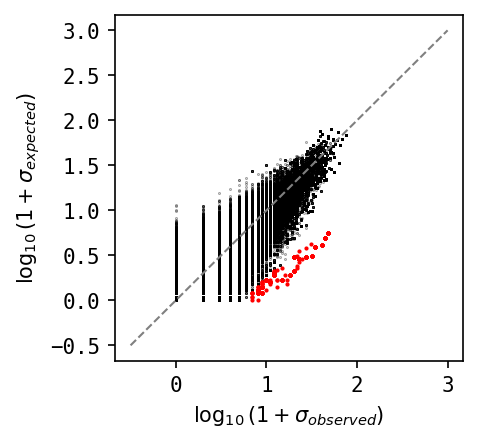

In [174]:
a3101 = pd.read_csv("./analysis/qfactor/A3-101_neighbors.txt", sep="\t")

fig, ax = plt.subplots(dpi=150,figsize=(3,3))
x = (a3101.fg+1).apply(lambda x: np.log10(x))
y = (a3101.expected_shuffled+1).apply(lambda x: np.log10(x))
# rat = x**2/y
ax.scatter(x,y,s=.1,c="black", alpha=.5)
# ax.plot([.5,2],[0,2.75])
# ax.plot([.75,1.75],[0,1]) 
c2 = y < np.interp(x,[.75,1.75],[0,1])
x2 = (a3101[c2].fg+1).apply(lambda x: np.log10(x))
y2 = (a3101[c2].expected_shuffled+1).apply(lambda x: np.log10(x))
ax.scatter(x2,y2,s=1,c="red")
ax.plot([-.5,3],[-.5,3], c="grey", lw=1, ls="--")

ax.set_xlabel(r"$\log_{10}(1+\sigma_{observed})$")
ax.set_ylabel(r"$\log_{10}(1+\sigma_{expected})$")

In [189]:
a5s14

,v_call,junction_aa,bg_vmatched,fg,bg_shuffled,bg_olga,expected_shuffled,expected_vmatched,expected_olga
0,TRBV12-4*01,CASSLPLLHNEQFF,0,0,0,0,0.0,0.0,0.0
1,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
2,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
3,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
4,TRBV27*01,CASSPGTDTQYF,5,1,14,3,1.4,0.5,0.3
...,...,...,...,...,...,...,...,...,...
51495,TRBV29-1*01,CSVGYTF,11,3,12,3,1.2,1.1,0.3
51496,TRBV29-1*01,CSVGGYF,16,2,9,3,0.9,1.6,0.3
51497,TRBV29-1*01,CSVEAFF,19,2,13,3,1.3,1.9,0.3
51498,TRBV29-1*01,CSDEKYF,18,3,10,1,1.0,1.8,0.1


,v_call,junction_aa,fg,expected_shuffled,expected_vmatch,expected_olga
2641,TRBV6-4*01,CASSDSAGGTDTQYF,6,0.2,0.0,0.3
12158,TRBV6-4*01,CASSDSGTDTQYF,10,0.6,0.4,2.0
17724,TRBV6-4*01,CASSDSSGGTDTQYF,9,0.7,0.1,0.6
37226,TRBV6-4*01,CASSDSGGGTDTQYF,8,0.6,0.0,0.7
88062,TRBV6-4*01,CASSDSQGGTDTQYF,7,0.4,0.1,0.9
220764,TRBV6-4*01,CASSDSGGTDTQYF,11,1.1,0.0,1.2


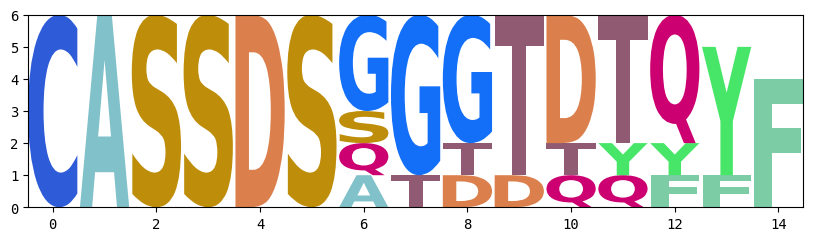

In [181]:
# c1 = y > np.interp(x, x,yy)

col_order = ["v_call","junction_aa", "fg", "expected_shuffled", "expected_vmatch", "expected_olga"] 
offset = a3101[c2].drop_duplicates()[col_order]
plot_cluster_logo(offset[offset.v_call=="TRBV6-4*01"])
offset[offset.v_call=="TRBV6-4*01"]

In [182]:
offset[offset.v_call=="TRBV6-4*01"].junction_aa

"CASSDSAGGTDTQYF"
"CASSDS--GTDTQYF"
"CASSDSGGGTDTQYF"
"CASSDSQGGTDTQYF"
"CASSDS-GGTDTQYF"

CASSDS[AGQ]GGTDTQYF

2641      CASSDSAGGTDTQYF
12158       CASSDSGTDTQYF
17724     CASSDSSGGTDTQYF
37226     CASSDSGGGTDTQYF
88062     CASSDSQGGTDTQYF
220764     CASSDSGGTDTQYF
Name: junction_aa, dtype: object

323       CSARDPDLSSYEQYF
2647      CSARDPDRSSYEQYF
5693      CSARDKDRSSYEQYF
6744      CSARDGDRSSYEQYF
6870      CSARDPDMSSYEQYF
7617      CSAKDPDRSSYEQYF
9719      CSARDPDISSYEQYF
11528     CSARDRDRSSYEQYF
14068     CSARDPDKSSYEQYF
17801     CSARDQDRSSYEQYF
19004     CSARVSDRSSYEQYF
22071     CSARVPDRSSYEQYF
22082     CSARVRDRSSYEQYF
23542     CSARDSDRSSYEQYF
32032     CSARDADRSSYEQYF
32096     CSARERDRSSYEQYF
38004     CSARDPDASSYEQYF
38007     CSARDIDRSSYEQYF
46459     CSARDSDKSSYEQYF
46477     CSARDTDRSSYEQYF
60969     CSARYRDRSSYEQYF
61027     CSARDPERSSYEQYF
94571     CSARHRDRSSYEQYF
94616     CSARNSDRSSYEQYF
94845     CSARDPDYSSYEQYF
94941     CSARDMDRSSYEQYF
94978     CSARDEDRSSYEQYF
95049     CSAKVRDRSSYEQYF
204077    CSARARDRSSYEQYF
204339    CSARLRDRSSYEQYF
205048    CSARDPPRSSYEQYF
205533    CSARDPDTSSYEQYF
205631    CSAREVGGAGQPQHF
205823    CSARNRDRSSYEQYF
Name: junction_aa, dtype: object

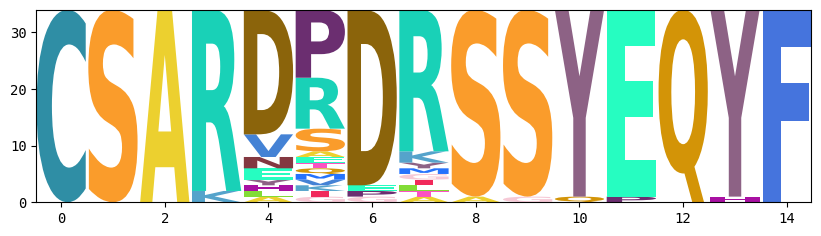

In [187]:
plot_cluster_logo(offset[offset.v_call=="TRBV20-1*01"])
offset[offset.v_call=="TRBV20-1*01"].junction_aa



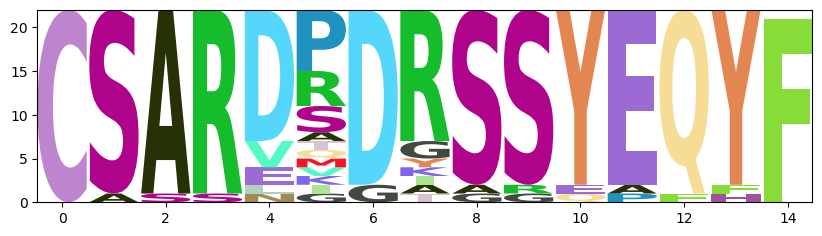

In [129]:
import logomaker
import random

def plot_cluster_logo(cluster):
    seqlen = len(cluster.junction_aa.iloc[0])
    aas = []
    for i in cluster.junction_aa:
        aas += i
    aas = sorted(list(set(aas)))
    color_dict = {aa: (random.random(), random.random(), random.random()) for aa in aas}
    pos_matrix = np.zeros((seqlen,len(aas)))
    aa_dict = {i:[0]*seqlen for i in aas}
    for pos in range(seqlen):
        aacount = cluster.junction_aa.str[pos].value_counts()
        for i in aacount.index:
            aa_dict[i][pos] = aacount[i]
    pos_df = pd.DataFrame(aa_dict)
    # create Logo object
    logo = logomaker.Logo(pos_df, color_scheme=color_dict)

plot_cluster_logo(offset)

In [130]:
offset

,v_call,junction_aa,fg,expected_shuffled,expected_vmatch,expected_olga
2647,TRBV20-1*01,CSARDPDRSSYEQYF,43,3.9,0.1,0.0
5693,TRBV20-1*01,CSARDKDRSSYEQYF,30,3.2,0.1,0.1
6744,TRBV20-1*01,CSARDGDRSSYEQYF,26,2.0,0.3,0.2
9719,TRBV20-1*01,CSARDPDISSYEQYF,16,0.5,0.1,0.0
11528,TRBV20-1*01,CSARDRDRSSYEQYF,47,4.6,0.4,0.4
14068,TRBV20-1*01,CSARDPDKSSYEQYF,17,0.9,0.1,0.0
17801,TRBV20-1*01,CSARDQDRSSYEQYF,26,2.8,0.0,0.1
19004,TRBV20-1*01,CSARVSDRSSYEQYF,14,0.7,0.2,0.1
22071,TRBV20-1*01,CSARVPDRSSYEQYF,19,1.1,0.1,0.1
22082,TRBV20-1*01,CSARVRDRSSYEQYF,22,1.9,0.1,0.1


In [117]:
from Levenshtein import distance as levdist

vdjdb_seq_a = "CSARDSGDSSYEQYF"
vdjdb_seq_b = "CSARDPGGRSSYEQYF"
vdjdb_seq_c = "CSARDLDSLSYEQYF"

for aaseq in a3101[c2].drop_duplicates()[col_order].junction_aa:
    print(aaseq)
    print(levdist(aaseq, vdjdb_seq_a), levdist(aaseq, vdjdb_seq_a), levdist(aaseq, vdjdb_seq_a))

CSARDPDRSSYEQYF
3 3 3
CSARDKDRSSYEQYF
3 3 3
CSARDGDRSSYEQYF
2 2 2
CSARDPDISSYEQYF
3 3 3
CSARDRDRSSYEQYF
3 3 3
CSARDPDKSSYEQYF
3 3 3
CSARDQDRSSYEQYF
3 3 3
CSARVSDRSSYEQYF
3 3 3
CSARVPDRSSYEQYF
4 4 4
CSARVRDRSSYEQYF
4 4 4
CSARDSDRSSYEQYF
2 2 2
CSARDADRSSYEQYF
3 3 3
CSARDPDASSYEQYF
3 3 3
CSARDIDRSSYEQYF
3 3 3
CSARDTDRSSYEQYF
3 3 3
CSARDPDYSSYEQYF
3 3 3
CSARDMDRSSYEQYF
3 3 3
CASSESGGGREAFF
10 10 10
CSARLRDRSSYEQYF
4 4 4
CSARDPDTSSYEQYF
3 3 3
CSAREVGGAGQPQHF
8 8 8
CSARNRDRSSYEQYF
4 4 4
